# Bilateral Solver Demo

This notebook demos a barebones Python implementation of the bilateral solver.

In [1]:
%pylab inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'CMRmap'
rcParams['figure.facecolor'] = 'w'

Populating the interactive namespace from numpy and matplotlib


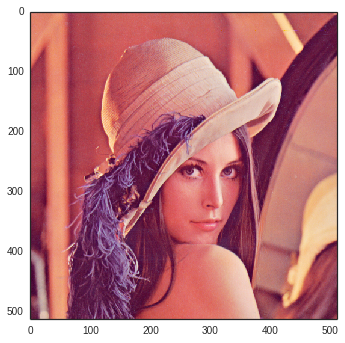

In [2]:
from skimage import data
lena = data.lena()
imshow(lena)

### RGB-YUV conversion
Actually doing RGB-YCbCr. Math from https://en.wikipedia.org/wiki/YCbCr#JPEG_conversion

In [3]:
RGB_TO_YUV = np.array([
    [ 0.299,     0.587,     0.114],
    [-0.168736, -0.331264,  0.5],
    [ 0.5,      -0.418688, -0.081312]])
YUV_TO_RGB = np.array([
    [1.0,  0.0,      1.402],
    [1.0, -0.34414, -0.71414],
    [1.0,  1.772,    0.0]])
YUV_OFFSET = np.array([0, 128.0, 128.0]).reshape(1, 1, -1)

def rgb2yuv(im):
    return np.tensordot(im, RGB_TO_YUV, ([2], [1])) + YUV_OFFSET

def yuv2rgb(im):
    return np.tensordot(im.astype(float) - YUV_OFFSET, YUV_TO_RGB, ([2], [1]))

## Bilateral Grid
Implement the bilateral grid using a hacky hashing function to go from coordinates to unique numbers.

In [4]:
MAX_VAL = 255.0
from scipy.sparse import csr_matrix

def get_valid_idx(valid, candidates):
    """Find which values are present in a list and where they are located"""
    locs = np.searchsorted(valid, candidates)
    # Handle edge case where the candidate is larger than all valid values
    locs = np.clip(locs, 0, len(valid) - 1)
    # Identify which values are actually present
    valid_idx = np.flatnonzero(valid[locs] == candidates)
    locs = locs[valid_idx] 
    return valid_idx, locs

class BilateralGrid(object):
    def __init__(self, im, sigma_spatial=32, sigma_luma=8, sigma_chroma=8):
        im_yuv = rgb2yuv(im)
        # Compute 5-dimensional XYLUV bilateral-space coordinates
        Iy, Ix = np.mgrid[:im.shape[0], :im.shape[1]]
        x_coords = (Ix / sigma_spatial).astype(int)
        y_coords = (Iy / sigma_spatial).astype(int)
        luma_coords = (im_yuv[..., 0] /sigma_luma).astype(int)
        chroma_coords = (im_yuv[..., 1:] / sigma_chroma).astype(int)
        coords = np.dstack((x_coords, y_coords, luma_coords, chroma_coords))
        coords_flat = coords.reshape(-1, coords.shape[-1])
        self.npixels, self.dim = coords_flat.shape
        # Hacky "hash vector" for coordinates.
        self.hash_vec = (MAX_VAL**np.arange(self.dim))
        # Construct S and B matrix
        self._compute_factorization(coords_flat)
        
    def _compute_factorization(self, coords_flat):
        # Hash each coordinate in grid to a unique value
        hashed_coords = self._hash_coords(coords_flat)
        unique_hashes, unique_idx, idx = \
            np.unique(hashed_coords, return_index=True, return_inverse=True) 
        # Identify unique set of vertices
        unique_coords = coords_flat[unique_idx]
        self.nvertices = len(unique_coords)
        # Construct sparse splat matrix that maps from pixels to vertices
        self.S = csr_matrix((np.ones(self.npixels), (idx, np.arange(self.npixels))))
        # Construct sparse blur matrices.
        # Note that these represent [1 0 1] blurs, excluding the central element
        self.blurs = []
        for d in xrange(self.dim):
            blur = 0.0
            for offset in (-1, 1):
                offset_vec = np.zeros((1, self.dim))
                offset_vec[:, d] = offset
                neighbor_hash = self._hash_coords(unique_coords + offset_vec)
                valid_coord, idx = get_valid_idx(unique_hashes, neighbor_hash)
                blur = blur + csr_matrix((np.ones((len(valid_coord),)),
                                          (valid_coord, idx)),
                                         shape=(self.nvertices, self.nvertices))
            self.blurs.append(blur)
        
    def _hash_coords(self, coord):
        """Hacky function to turn a coordinate into a unique value"""
        return np.dot(coord.reshape(-1, self.dim), self.hash_vec)

    def splat(self, x):
        return self.S.dot(x)
    
    def slice(self, y):
        return self.S.T.dot(y)
    
    def blur(self, x):
        """Blur a bilateral-space vector with a 1 2 1 kernel in each dimension"""
        assert x.shape[0] == self.nvertices
        out = 2 * self.dim * x
        for blur in self.blurs:
            out = out + blur.dot(x)
        return out

    def filter(self, x):
        """Apply bilateral filter to an input x"""
        return self.slice(self.blur(self.splat(x))) /  \
               self.slice(self.blur(self.splat(np.ones_like(x))))

## Bilateral Solver
Barebenes implementation using the flat initializer and Jacobi preconditioner.

In [5]:
from scipy.sparse import diags
from scipy.sparse.linalg import cg

def bistochastize(grid, maxiter=10):
    """Compute diagonal matrices to bistochastize a bilateral grid"""
    m = grid.splat(np.ones(grid.npixels))
    n = np.ones(grid.nvertices)
    for i in xrange(maxiter):
        n = np.sqrt(n * m / grid.blur(n))
    Dm = diags(m, 0)
    Dn = diags(n, 0)
    return Dn, Dm

class BilateralSolver(object):
    def __init__(self, grid, lam=8.0, **kwargs):
        self.grid = grid
        self.lam = lam
        self.Dn, self.Dm = bistochastize(grid)
    
    def solve(self, x, w):
        A_smooth = (self.Dm - self.Dn.dot(self.grid.blur(self.Dn)))
        A_data = diags(self.grid.splat(w), 0)
        A = self.lam * A_smooth + A_data
        xw = x * w[:, np.newaxis]
        b = self.grid.splat(xw)
        # Use simple Jacobi preconditioner
        M = diags(1 / A.diagonal(), 0)
        # Flat initialization
        y0 = self.grid.splat(xw) / self.grid.splat(w[:, np.newaxis])
        yhat = np.empty_like(y0)
        for d in xrange(x.shape[-1]):
            yhat[..., d], info = cg(A, b[..., d], x0=y0[..., d], M=M)
        xhat = self.grid.slice(yhat)
        return xhat

## Construct a simple dataset with a noisy version of the input image

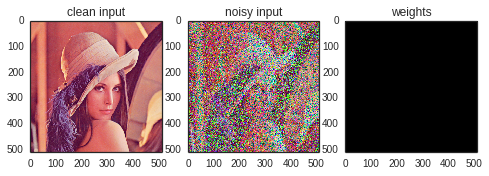

In [6]:
# Construct simple dataset containing a noisy version of the image
im = lena.copy()
im_shape = im.shape
x = im.reshape(-1, 3) / 255.0
noise_std = 0.2
xnoise = x  + noise_std * np.random.randn(*x.shape)
w = np.ones_like(xnoise)[:, 0]

imargs = dict(vmin=0, vmax=1)
subplot(131)
imshow(im, **imargs)
title('clean input')
subplot(132)
imshow(xnoise.reshape(im_shape), **imargs)
title('noisy input')
subplot(133)
imshow(w.reshape(im_shape[:2])); 
title('weights');

## Set parameters

In [7]:
grid_params = {
    'sigma_luma' : 6,
    'sigma_chroma': 6,
    'sigma_spatial': 16
}

bs_params = {
    'lam': 128
}

## Run bilateral filter and solver

In [8]:
%%time
grid = BilateralGrid(im, **grid_params)
xhat_bf = grid.filter(xnoise)

CPU times: user 182 ms, sys: 449 ms, total: 631 ms
Wall time: 134 ms


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [9]:
%%time
grid = BilateralGrid(im, **grid_params)
xhat = BilateralSolver(grid, **bs_params).solve(xnoise, w)

CPU times: user 467 ms, sys: 1.39 s, total: 1.85 s
Wall time: 312 ms


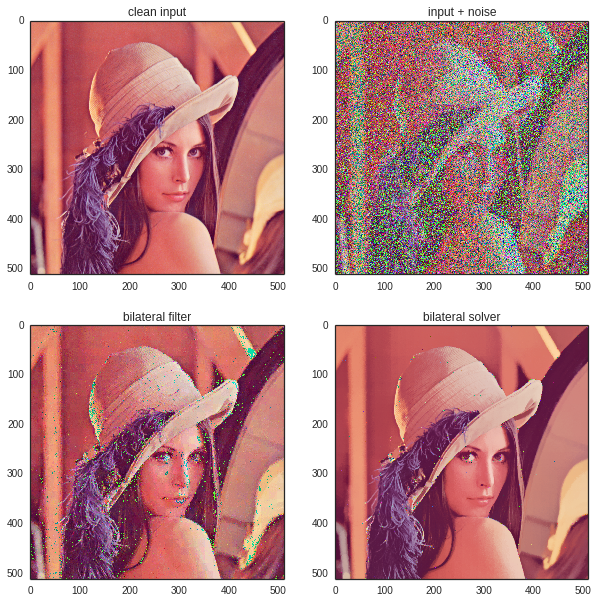

In [10]:
figure(figsize=(10, 10))
subplot(221)
imshow(x.reshape(im_shape), **imargs)
title('clean input')
subplot(222)
imshow(xnoise.reshape(im_shape), **imargs)
title('input + noise')
subplot(223)
imshow(xhat_bf.reshape(im_shape), **imargs)
title('bilateral filter')
subplot(224)
imshow(xhat.reshape(im_shape), **imargs)
title('bilateral solver');